In [1]:
# Import required libraries
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

## 1. Get and process Fashion MNIST dataset

### 1.1 Download Fashion MNIST dataset

In [2]:
# torchvision.datasets can be used for downloading Fashion MNIST data
train_data = datasets.FashionMNIST(
    root='data', # where to download data to?
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:01<00:00, 15951577.16it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 270130.54it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4989418.69it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18614031.89it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
# Check the length of train_data and test_data
len(train_data), len(test_data)

(60000, 10000)

In [4]:
# Check classes/labels in data
# There are 10 labels
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
# class_to_idx returns a Python dictionary mapping class names to integers
train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [6]:
# Visualize an image
image, label = train_data[0]

In [7]:
print(f'Shape of image: {image.shape}')
print(f'Image label: {label}')

Shape of image: torch.Size([1, 28, 28])
Image label: 9


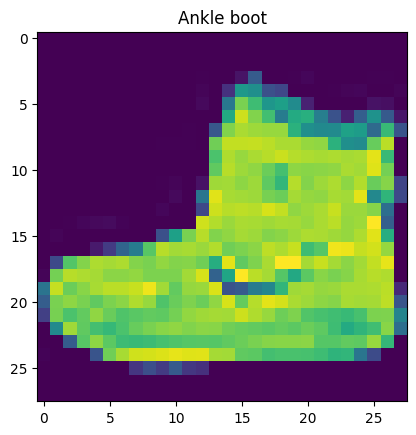

In [8]:
# Need to use squeeze to remove the single dimension from image because plt.imshow requires data to be in format (M, N) or (M, N, c)
# M and N define the rows and columns of the image, c is color channel
plt.imshow(image.squeeze())
plt.title(class_names[label]);

### 1.2 Prepare DataLoader
DataLoader turns a dataset into a Python iterable, so we can pass batches of images into a model instead of training the model with tens of thousands of images at once.

DataLoader can reshuffle the data at every epoch to reduce overfitting.

In [5]:
from torch.utils.data import DataLoader

# Set up the batch_size parameter
# batch_size refers to the number of images in one batch
BATCH_SIZE = 32

# Turn datasets into dataloaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True) # Set shufflt=True to reduce model overfitting

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False) # Shuffle isn't required for testing data

In [10]:
# Check out the length of dataloaders
print(f'Length of train_dataloader: {len(train_dataloader)}')
print(f'Length of test_dataloader: {len(test_dataloader)}')

Length of train_dataloader: 1875
Length of test_dataloader: 313


In [11]:
# Check out what's inside the dataloader
# Each iteration in dataloader returns a batch of features and labels
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(f'Shape of features in dataloader: {train_features_batch.shape}')
print(f'Shape of labels in dataloader: {train_labels_batch.shape}')

Shape of features in dataloader: torch.Size([32, 1, 28, 28])
Shape of labels in dataloader: torch.Size([32])


## 2. Model 0: Baseline model for image classification

### 2.1 Build the model

This baseline model is a simple neural network containing only 2 layers:
- **1 Flatten layer**: Reshape dimensions of a tensor, which can then be passed into a linear layer.
- **1 Linear layer**: Apply linear transformation on the input.

In [116]:
class BaselineModel(nn.Module):
  """
  This is a baseline model for image classification.

  Args:
    input_shape (int): # of features. This equals the total number of pixels in an image.
    output_shape (int): # of classes
    x: Image tensor

  Returns:
    Raw logits of forward pass calculation
  """
  def __init__(self, input_shape: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=output_shape)
    )

  def forward(self, x):
    logits = self.layer_stack(x)
    return logits

In [120]:
# Create an instance of BaselineModel
# Set random seed for reproducibility
torch.manual_seed(42)

model_0 = BaselineModel(input_shape=28*28,
                        output_shape=len(class_names))
model_0

BaselineModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
  )
)

### 2.2 Set up loss function, optimizer, and evaluation metric
- **Loss function**: Cross-entropy loss
- **Optimizer**: Stochastic gradient descent
- **Evaluation metric**: Accuracy

In [ ]:
# Set up device agnostic code to GPU to run codes faster
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [121]:
# !pip install torchmetrics
from torchmetrics import Accuracy
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)
accuracy_fn = Accuracy(task="multiclass", num_classes=len(class_names)).to(device)

### 2.3 Create loops to train and test the model
**Steps to create the loops:**

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate cross-entropy loss and accuracy on training data.
3. Loop through testing batches, perform testing steps, calculate cross-entropy loss and accuracy on testing data.
4. Print out results.

In [122]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Set the number of epochs
epochs = 3

# Create training and testing loop
for epoch in range(epochs):

  ### Training
  # Initialize train loss and accuracy
  train_loss_total, train_accuracy_total = 0, 0

  # Set model to train mode
  model_0.train()
  model_0.to(device)

  # Loop through training batches:
  for X_train, y_train in train_dataloader:
    # Send data to GPU
    X_train, y_train = X_train.to(device), y_train.to(device)

    # 1. Calculate forward pass
    y_logits_train = model_0(X_train)

    # 2. Calculate and accumulate train loss and train accuracy
    train_loss = loss_fn(y_logits_train, y_train)
    train_accuracy = accuracy_fn(y_logits_train.argmax(dim=1), y_train)
    train_loss_total += train_loss
    train_accuracy_total += train_accuracy

    # 3. Optimizer zero grad
    optimizer.zero_grad() # Zero out gradients, otherwise gradients get accumulated and model parameters can't be updated correctly

    # 4. Loss backward
    train_loss.backward()

    # 5. Optimizer step to update model parameters
    optimizer.step()

  # Calculate average train loss and accuracy per batch
  train_loss_total /= len(train_dataloader)
  train_accuracy_total /= len(train_dataloader)

  ### Testing
  # Initialize test loss and accuracy
  test_loss_total, test_accuracy_total = 0, 0

  model_0.eval()
  model_0.to(device)
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      # Send data to GPU
      X_test, y_test = X_test.to(device), y_test.to(device)

      # 1. Calculate forward pass
      y_logits_test = model_0(X_test)

      # 2. Calculate and accumulate test loss and train accuracy
      test_loss = loss_fn(y_logits_test, y_test)
      test_accuracy = accuracy_fn(y_logits_test.argmax(dim=1), y_test)
      test_loss_total += test_loss
      test_accuracy_total += test_accuracy

  # Calculate average test loss and accuraqcy per batch
    test_loss_total /= len(test_dataloader)
    test_accuracy_total /= len(test_dataloader)

  # Print out results
  print(f'Epoch: {epoch} | Train loss: {train_loss_total:.4f} | Train accuracy: {train_accuracy_total:.2%} |\
    Test loss: {test_loss_total:.4f} | Test accuracy: {test_accuracy_total:.2%}')

Epoch: 0 | Train loss: 0.5927 | Train accuracy: 79.81% |    Test loss: 0.4937 | Test accuracy: 83.16%
Epoch: 1 | Train loss: 0.4862 | Train accuracy: 83.32% |    Test loss: 0.4786 | Test accuracy: 83.18%
Epoch: 2 | Train loss: 0.4629 | Train accuracy: 84.09% |    Test loss: 0.4698 | Test accuracy: 83.72%


### 2.4 Get model_0 results

In [123]:
# Define a function to evaluate a model
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module=nn.CrossEntropyLoss(),
               accuracy_fn=accuracy_fn,
               device=device):
  """
  Evaluates a given model on a dataset.

  Args:
      model (torch.nn.Module): A PyTorch model capable of making predictions on dataloader.
      data_loader (torch.utils.data.DataLoader): The target dataloader to predict on.
      loss_fn (torch.nn.Module): Loss function of model.
      accuracy_fn: Accuracy function to compare model predictions to labels.

  Returns:
      (dict): Results of model predictions.
  """
  loss, acc = 0, 0
  model.eval()
  model.to(device)
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_pred.argmax(dim=1), y)

    # Average loss and accuracy per batch
    loss /= len(data_loader)
    acc /= len(data_loader)
  return {"model_loss": loss.item(),
          "model_acc": acc.item()*100}

In [124]:
# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader)
model_0_results

{'model_loss': 0.4697604477405548, 'model_acc': 83.71605277061462}

## 3. Model 1: TinyVGG model for image classification
To understand TinyVGG, we need to firstly know what convolutional neural network is.

**Convolutional neural network (CNN)** is a neural network that uses a special type of layer, called convolutional layer which is good at learning patterns from images or image-like data.

**VGG** is a deep CNN architecture consisting of many convolutional layers to classify an image.

**TinyVGG** contains many of the same layers as a VGG model but on a smaller scale.

### 3.1 Define functions for training and testing loops
Define 2 functions. When looping through epochs, no need to repeat writing codes for training and testing loops.
- `train_step()`
- `test_step()`

In [20]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               loss_fn: torch.nn.Module=nn.CrossEntropyLoss(),
               accuracy_fn=accuracy_fn,
               device=device):
  model.train()
  model.to(device)
  train_loss, train_acc = 0, 0
  for X, y in data_loader:
    # Send data to GPU
    X, y = X.to(device), y.to(device)
    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_pred.argmax(dim=1), y) # Go from logits -> pred labels

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  # Calculate loss and accuracy per epoch and print out what's happening
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.2%}")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module=nn.CrossEntropyLoss(),
              accuracy_fn=accuracy_fn,
              device=device):

  test_loss, test_acc = 0, 0
  # Set model to evaluation mode
  model.eval()
  model.to(device)
  # Turn on inference context manager
  with torch.inference_mode():
    for X, y in data_loader:
      # Send data to GPU
      X, y = X.to(device), y.to(device)
      # 1. Forward pass
      test_pred = model(X)

      # 2. Calculate loss and accuracy
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(test_pred.argmax(dim=1), y) # Go from logits -> pred labels

    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.2%}")

### 3.2 Build the TinyVGG model
I followed this website to build the TinyVGG model:

https://poloclub.github.io/cnn-explainer/

In TinyVGG, there are 3 important layers:
- **Convolutional layer**:
  - Convolutional layer consists of neurons performing a dot product of a kernel learned by the network and the output of the previous layer's neuron.
  - The goal of adding a convolutional layer is to convert all receptive pixels in a kernel to a single number, which can be then used for calculating the output of a convolutional neuron.

- **ReLU layer**:
  - ReLU, standing for rectified linear unit, applies an element-wise non-linear transformation to input data and decides which pixel in the output of a convolutional neuron gets activated.
  - ReLU(x) = max(0, x), so when an input value is larger than 0, it will be returned, otherwise 0 will be returned.

- **Max pooling layer**
  - Max pooling layer returns the maximum value in a kernel.
  - The goal of adding a max pooling layer is to reduce the spatial extent of the network, thus making the TinyVGG more computationally efficient and reducing overfitting.

In [15]:
# Create a convolutional neural network
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int): # input_shape is the # of color channels
    super().__init__()
    self.block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3, # how big is the kernel that's going over the image?
                padding=1), # Adding extra pixels around an input image to prevent spatial shrinking when applying convolution operations. This allows the network to learn from the edges of the image, which would otherwise be lost in the convolution process.
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2) # default stride value is same as kernel_size
    )
    self.block_2 = nn.Sequential(
      nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
      nn.Flatten(),
      # Where did this in_features shape come from?
      # It's because each layer of our network compresses and changes the shape of our inputs data.
      nn.Linear(in_features=hidden_units*7*7,
                out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    return self.classifier(self.block_2(self.block_1(x)))

In [21]:
# Instantiate an instance of TinyVGG
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=1,
                  hidden_units=10,
                  output_shape=len(class_names))
model_1

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [22]:
# Set up optimizer
optimizer_model_1 = torch.optim.SGD(params=model_1.parameters(),
                                    lr=0.1)

### 3.3 Train and test TinyVGG model

In [23]:
torch.manual_seed(42)

epochs = 3
for epoch in range(epochs):
  print(f'Epoch: {epoch}\n')
  # Use defined train_step and test_step for training and testing
  train_step(model=model_1,
             data_loader=train_dataloader,
             optimizer=optimizer_model_1)

  test_step(model=model_1,
            data_loader=test_dataloader)

Epoch: 0

Train loss: 0.5952 | Train accuracy: 78.37%
Test loss: 0.3965 | Test accuracy: 85.63%
Epoch: 1

Train loss: 0.3580 | Train accuracy: 86.94%
Test loss: 0.3473 | Test accuracy: 87.30%
Epoch: 2

Train loss: 0.3197 | Train accuracy: 88.41%
Test loss: 0.3175 | Test accuracy: 88.58%


### 3.4 Get model_1 results

In [125]:
model_1_results = eval_model(model_1,
                             test_dataloader)
model_1_results

{'model_loss': 0.3174608051776886, 'model_acc': 88.57827186584473}

## 4. Experiment with different approaches to improve model performance
model_1's accuracy on testing data is 88%, meaning it can correctly determine the type of 88 out of 100 clothes.

This indicates good performance of the model, but I'm going to experiment with 3 approaches below to improve the model performance:


1. **Implement data augmentation**
2. **Train model for more epochs**
3. **Change optimizer's learning rate**

### 4.1 Implement data augmentation
**Data augmentation** is a technique used for adding new data to existing training data by applying transformations to training data, such as changing the color and brightness of an image, or rotating and flipping an image.

Apply **RandAugment** to images in the training data and test if this augmentation will improve model performance.

**RandAugment** sequentially applies several augmentation transformations to images.

#### 4.1.1 Apply data augmentation and prepare training data

In [27]:
# Define data augmentation transformation
data_augmentation_transform = transforms.Compose([transforms.RandAugment(num_ops=2),
                                                  ToTensor()])

In [28]:
# Apply data augmentation transformation to training data
train_data_augmented = datasets.FashionMNIST(root='data',
                                             train=True,
                                             transform=data_augmentation_transform)

In [29]:
# Turn datasets into dataloaders
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True)

#### 4.1.2 Train and test TinyVGG model using augmented training data

In [38]:
# Instantiate an instance of TinyVGG
torch.manual_seed(42)
model_2 = TinyVGG(input_shape=1,
                  hidden_units=10,
                  output_shape=len(class_names))
model_2

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [39]:
# Set up optimizer
optimizer_model_2 = torch.optim.SGD(params=model_2.parameters(),
                                    lr=0.1)

In [40]:
torch.manual_seed(42)

epochs = 3
for epoch in range(epochs):
  print(f'Epoch: {epoch}\n')
  # Use defined train_step and test_step for training and testing
  train_step(model=model_2,
             data_loader=train_dataloader_augmented,
             optimizer=optimizer_model_2)

  test_step(model=model_2,
            data_loader=test_dataloader)

Epoch: 0

Train loss: 0.8004 | Train accuracy: 70.48%
Test loss: 0.4262 | Test accuracy: 84.76%
Epoch: 1

Train loss: 0.5152 | Train accuracy: 81.05%
Test loss: 0.3753 | Test accuracy: 86.40%
Epoch: 2

Train loss: 0.4619 | Train accuracy: 83.19%
Test loss: 0.3675 | Test accuracy: 86.95%


#### 4.1.3 Get model_2 results

Compared to the TinyVGG model trained without data augmentation, this model's performance is a bit worse.

In [126]:
model_2_results = eval_model(model_2,
                             test_dataloader)
model_2_results

{'model_loss': 0.3675119876861572, 'model_acc': 86.95087432861328}

#### 4.1.4 Combine original training data and augmented training data for training

Experiment with this approach to see if model performance can be improved.

In [43]:
train_data_combined = torch.utils.data.ConcatDataset([train_data_augmented, train_data])

In [44]:
# Turn datasets into dataloaders
train_dataloader_combined = DataLoader(dataset=train_data_combined,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True)

#### 4.1.5 Train and test TinyVGG model using combined training data

In [45]:
# Instantiate an instance of TinyVGG
torch.manual_seed(42)
model_3 = TinyVGG(input_shape=1,
                  hidden_units=10,
                  output_shape=len(class_names))
model_3

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [46]:
# Set up optimizer
optimizer_model_3 = torch.optim.SGD(params=model_3.parameters(),
                                    lr=0.1)

In [47]:
torch.manual_seed(42)

epochs = 3
for epoch in range(epochs):
  print(f'Epoch: {epoch}\n')
  # Use defined train_step and test_step for training and testing
  train_step(model=model_3,
             data_loader=train_dataloader_combined,
             optimizer=optimizer_model_3)

  test_step(model=model_3,
            data_loader=test_dataloader)

Epoch: 0

Train loss: 0.6298 | Train accuracy: 76.87%
Test loss: 0.4084 | Test accuracy: 84.49%
Epoch: 1

Train loss: 0.4287 | Train accuracy: 84.26%
Test loss: 0.3471 | Test accuracy: 87.25%
Epoch: 2

Train loss: 0.4036 | Train accuracy: 85.16%
Test loss: 0.3530 | Test accuracy: 87.40%


#### 4.1.6 Get model_3 results
Combined training data results in better performance than training the TinyVGG model with only augmented data. This model's performance is very close to but still worse than the 1st model's performance.

In [127]:
model_3_results = eval_model(model_3,
                             test_dataloader)
model_3_results

{'model_loss': 0.35302624106407166, 'model_acc': 87.40015625953674}

### 4.2 Train model for more epochs
Instead of having epochs set to 3, set it to 5 and see if this improves model performance.

#### 4.2.1 Train and test TinyVGG model with epochs=5

In [56]:
# Instantiate an instance of TinyVGG
torch.manual_seed(42)
model_4 = TinyVGG(input_shape=1,
                  hidden_units=10,
                  output_shape=len(class_names))
model_4

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [57]:
# Set up optimizer
optimizer_model_4 = torch.optim.SGD(params=model_4.parameters(),
                                    lr=0.1)

In [58]:
torch.manual_seed(42)

epochs = 5
for epoch in range(epochs):
  print(f'Epoch: {epoch}\n')
  # Use defined train_step and test_step for training and testing
  train_step(model=model_4,
             data_loader=train_dataloader,
             optimizer=optimizer_model_4)

  test_step(model=model_4,
            data_loader=test_dataloader)

Epoch: 0

Train loss: 0.5948 | Train accuracy: 78.43%
Test loss: 0.4009 | Test accuracy: 85.87%
Epoch: 1

Train loss: 0.3611 | Train accuracy: 86.99%
Test loss: 0.3522 | Test accuracy: 87.10%
Epoch: 2

Train loss: 0.3232 | Train accuracy: 88.28%
Test loss: 0.3231 | Test accuracy: 88.35%
Epoch: 3

Train loss: 0.3031 | Train accuracy: 88.90%
Test loss: 0.3154 | Test accuracy: 88.33%
Epoch: 4

Train loss: 0.2894 | Train accuracy: 89.47%
Test loss: 0.3080 | Test accuracy: 89.09%


#### 4.2.2 Get model_4 results
Training the TinyVGG model with 5 epochs doesn't improve model performance much compared to with 3 epochs.

In [128]:
model_4_results = eval_model(model_4,
                             test_dataloader)
model_4_results

{'model_loss': 0.3079548478126526, 'model_acc': 89.08745646476746}

### 4.3 Change optimizer's learning rate

#### 4.3.1 Train and test TinyVGG model with lr=0.2
Learning rate was set to 0.1 before, set it to 0.2 for this training.

In [60]:
# Instantiate an instance of TinyVGG
torch.manual_seed(42)
model_5 = TinyVGG(input_shape=1,
                  hidden_units=10,
                  output_shape=len(class_names))
model_5

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [61]:
# Set up optimizer
optimizer_model_5 = torch.optim.SGD(params=model_5.parameters(),
                                    lr=0.2)

In [62]:
torch.manual_seed(42)

epochs = 3
for epoch in range(epochs):
  print(f'Epoch: {epoch}\n')
  # Use defined train_step and test_step for training and testing
  train_step(model=model_5,
             data_loader=train_dataloader,
             optimizer=optimizer_model_5)

  test_step(model=model_5,
            data_loader=test_dataloader)

Epoch: 0

Train loss: 2.3042 | Train accuracy: 9.80%
Test loss: 2.3035 | Test accuracy: 9.99%
Epoch: 1

Train loss: 2.3041 | Train accuracy: 9.80%
Test loss: 2.3036 | Test accuracy: 9.99%
Epoch: 2

Train loss: 2.3042 | Train accuracy: 9.79%
Test loss: 2.3037 | Test accuracy: 9.99%


#### 4.3.2 Get model_5 results
Learning rate of 0.2 leads to poor results. This means 0.2 is too large to be used as learning rate.

In [129]:
model_5_results = eval_model(model_5,
                             test_dataloader)
model_5_results

{'model_loss': 2.303741216659546, 'model_acc': 9.994009137153625}

#### 4.3.3 Train and test TinyVGG model with lr=0.05

In [64]:
# Instantiate an instance of TinyVGG
torch.manual_seed(42)
model_6 = TinyVGG(input_shape=1,
                  hidden_units=10,
                  output_shape=len(class_names))
model_6

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [65]:
# Set up optimizer
optimizer_model_6 = torch.optim.SGD(params=model_6.parameters(),
                                    lr=0.05)

In [66]:
torch.manual_seed(42)

epochs = 3
for epoch in range(epochs):
  print(f'Epoch: {epoch}\n')
  # Use defined train_step and test_step for training and testing
  train_step(model=model_6,
             data_loader=train_dataloader,
             optimizer=optimizer_model_6)

  test_step(model=model_6,
            data_loader=test_dataloader)

Epoch: 0

Train loss: 0.6766 | Train accuracy: 75.53%
Test loss: 0.4461 | Test accuracy: 84.07%
Epoch: 1

Train loss: 0.4005 | Train accuracy: 85.55%
Test loss: 0.3721 | Test accuracy: 86.53%
Epoch: 2

Train loss: 0.3463 | Train accuracy: 87.56%
Test loss: 0.3381 | Test accuracy: 88.01%


#### 4.3.4 Get model_6 results
Learning rate of 0.05 results in a similar performance to the rate of 0.1.

In [130]:
model_6_results = eval_model(model_6,
                             test_dataloader)
model_6_results

{'model_loss': 0.33814677596092224, 'model_acc': 88.00918459892273}

## 5. Compare model results
Model 4 has the highest accuracy, meaning training model for more epochs best improves model performance.

Model 5 has the lowest accuracy due to the optimizer's learning rate being too large.

In [145]:
import pandas as pd
all_model_results = pd.DataFrame([model_0_results, model_1_results, model_2_results, model_3_results, \
                                  model_4_results, model_5_results, model_6_results])

In [146]:
all_model_results = all_model_results.reset_index().rename(columns={'index':'model'})
all_model_results = all_model_results.sort_values(by=['model_acc'], ascending=False)
all_model_results

,model,model_loss,model_acc
4,4,0.307955,89.087456
1,1,0.317461,88.578272
6,6,0.338147,88.009185
3,3,0.353026,87.400156
2,2,0.367512,86.950874
0,0,0.469760,83.716053
5,5,2.303741,9.994009
